In [1]:
import os
import numpy as np
import re
import csv
import glob
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from PIL import Image
import scipy
from scipy.misc import imresize
import pytorch_models
import torch
from torch.autograd import Variable as V
from torchvision import transforms as trn
from torch.nn import functional as F

In [245]:
# set up global variables and data directories
MODEL_FILE = "../../../project2/bermanm/netdissect/trained_cnns/resnet18_cam"
DATA_DIRECTORY = "../../../project/rcc/deep_learning_hack/netdissect/broden1_224/"
OUTPUT_FOLDER = "../../../project2/bermanm/netdissect/urban_nature/"

FEATURE_NAMES = ["layer4"]
classes = ["indoor", "nature", "urban outdoor"]
IMG_SIZE = 224
cpt_size = 112

CATAGORIES = ["object", "part","scene","texture","color", "material"]
BATCH_SIZE = 64
GPU = False
QUANTILE = 0.005

TALLY_BATCH_SIZE = 16
TALLY_AHEAD = 4

In [3]:
from loader.data_loader import SegmentationData
from loader.data_loader import SegmentationPrefetcher

In [172]:
# compute quantiles using less memory
# copy from the original code
class QuantileVector:
    def __init__(self, depth=1, resolution=24 * 1024, buffersize=None,
            dtype=None, seed=None):
        self.resolution = resolution
        self.depth = depth
        # Default buffersize: 128 samples (and smaller than resolution).
        if buffersize is None:
            buffersize = min(128, (resolution + 7) // 8)
        self.buffersize = buffersize
        self.samplerate = 1.0
        self.data = [np.zeros(shape=(depth, resolution), dtype=dtype)]
        self.firstfree = [0]
        self.random = np.random.RandomState(seed)
        self.extremes = np.empty(shape=(depth, 2), dtype=dtype)
        self.extremes.fill(np.NaN)
        self.size = 0
    
    def add(self, incoming):
        assert len(incoming.shape) == 2
        assert incoming.shape[1] == self.depth
        self.size += incoming.shape[0]
        # Convert to a flat numpy array.
        if self.samplerate >= 1.0:
            self._add_every(incoming)
            return
        # If we are sampling, then subsample a large chunk at a time.
        self._scan_extremes(incoming)
        chunksize = np.ceil[self.buffersize / self.samplerate]
        for index in range(0, len(incoming), chunksize):
            batch = incoming[index:index+chunksize]
            sample = batch[self.random.binomial(1, self.samplerate, len(batch))]
            self._add_every(sample)
        
    def _add_every(self, incoming):
        supplied = len(incoming)
        index = 0
        while index < supplied:
            ff = self.firstfree[0]
            available = self.data[0].shape[1] - ff
            if available == 0:
                if not self._shift():
                    # If we shifted by subsampling, then subsample.
                    incoming = incoming[index:]
                    if self.samplerate >= 0.5:
                        print('SAMPLING')
                        self._scan_extremes(incoming)
                    incoming = incoming[self.random.binomial(1, 0.5,
                        len(incoming - index))]
                    index = 0
                    supplied = len(incoming)
                ff = self.firstfree[0]
                available = self.data[0].shape[1] - ff
            copycount = min(available, supplied - index)
            self.data[0][:,ff:ff + copycount] = np.transpose(
                    incoming[index:index + copycount,:])
            self.firstfree[0] += copycount
            index += copycount

    def _shift(self):
        index = 0
        # If remaining space at the current layer is less than half prev
        # buffer size (rounding up), then we need to shift it up to ensure
        # enough space for future shifting.
        while self.data[index].shape[1] - self.firstfree[index] < (
                -(-self.data[index-1].shape[1] // 2) if index else 1):
            if index + 1 >= len(self.data):
                return self._expand()
            data = self.data[index][:,0:self.firstfree[index]]
            data.sort()
            if index == 0 and self.samplerate >= 1.0:
                self._update_extremes(data[:,0], data[:,-1])
            offset = self.random.binomial(1, 0.5)
            position = self.firstfree[index + 1]
            subset = data[:,offset::2]
            self.data[index + 1][:,position:position + subset.shape[1]] = subset
            self.firstfree[index] = 0
            self.firstfree[index + 1] += subset.shape[1]
            index += 1
        return True

    def _scan_extremes(self, incoming):
        # When sampling, we need to scan every item still to get extremes
        self._update_extremes(
                np.nanmin(incoming, axis=0),
                np.nanmax(incoming, axis=0))

    def _update_extremes(self, minr, maxr):
        self.extremes[:,0] = np.nanmin(
                [self.extremes[:, 0], minr], axis=0)
        self.extremes[:,-1] = np.nanmax(
                [self.extremes[:, -1], maxr], axis=0)

    def minmax(self):
        if self.firstfree[0]:
            self._scan_extremes(self.data[0][:,:self.firstfree[0]].transpose())
        return self.extremes.copy()

    def _expand(self):
        cap = self._next_capacity()
        if cap > 0:
            # First, make a new layer of the proper capacity.
            self.data.insert(0, np.empty(
                shape=(self.depth, cap), dtype=self.data[-1].dtype))
            self.firstfree.insert(0, 0)
        else:
            # Unless we're so big we are just subsampling.
            assert self.firstfree[0] == 0
            self.samplerate *= 0.5
        for index in range(1, len(self.data)):
            # Scan for existing data that needs to be moved down a level.
            amount = self.firstfree[index]
            if amount == 0:
                continue
            position = self.firstfree[index-1]
            # Move data down if it would leave enough empty space there
            # This is the key invariant: enough empty space to fit half
            # of the previous level's buffer size (rounding up)
            if self.data[index-1].shape[1] - (amount + position) >= (
                    -(-self.data[index-2].shape[1] // 2) if (index-1) else 1):
                self.data[index-1][:,position:position + amount] = (
                        self.data[index][:,:amount])
                self.firstfree[index-1] += amount
                self.firstfree[index] = 0
            else:
                # Scrunch the data if it would not.
                data = self.data[index][:,:amount]
                data.sort()
                if index == 1:
                    self._update_extremes(data[:,0], data[:,-1])
                offset = self.random.binomial(1, 0.5)
                scrunched = data[:,offset::2]
                self.data[index][:,:scrunched.shape[1]] = scrunched
                self.firstfree[index] = scrunched.shape[1]
        return cap > 0

    def _next_capacity(self):
        cap = np.ceil(self.resolution * np.power(0.67, len(self.data)))
        if cap < 2:
            return 0
        return max(self.buffersize, int(cap))

    def _weighted_summary(self, sort=True):
        if self.firstfree[0]:
            self._scan_extremes(self.data[0][:,:self.firstfree[0]].transpose())
        size = sum(self.firstfree) + 2
        weights = np.empty(
            shape=(size), dtype='float32') # floating point
        summary = np.empty(
            shape=(self.depth, size), dtype=self.data[-1].dtype)
        weights[0:2] = 0
        summary[:,0:2] = self.extremes
        index = 2
        for level, ff in enumerate(self.firstfree):
            if ff == 0:
                continue
            summary[:,index:index + ff] = self.data[level][:,:ff]
            weights[index:index + ff] = np.power(2.0, level)
            index += ff
        assert index == summary.shape[1]
        if sort:
            order = np.argsort(summary)
            summary = summary[np.arange(self.depth)[:,None], order]
            weights = weights[order]
        return (summary, weights)

    def quantiles(self, quantiles, old_style=False):
        if self.size == 0:
            return np.full((self.depth, len(quantiles)), np.nan)
        summary, weights = self._weighted_summary()
        cumweights = np.cumsum(weights, axis=-1) - weights / 2
        if old_style:
            # To be convenient with numpy.percentile
            cumweights -= cumweights[:,0:1]
            cumweights /= cumweights[:,-1:]
        else:
            cumweights /= np.sum(weights, axis=-1, keepdims=True)
        result = np.empty(shape=(self.depth, len(quantiles)))
        for d in range(self.depth):
            result[d] = np.interp(quantiles, cumweights[d], summary[d])
        return result

    def integrate(self, fun):
        result = None
        for level, ff in enumerate(self.firstfree):
            if ff == 0:
                continue
            term = np.sum(
                    fun(self.data[level][:,:ff]) * np.power(2.0, level),
                    axis=-1)
            if result is None:
                result = term
            else:
                result += term
        if result is not None:
            result /= self.samplerate
        return result

    def percentiles(self, percentiles):
        return self.quantiles(percentiles, old_style=True)

    def readout(self, count, old_style=True):
        return self.quantiles(
                np.linspace(0.0, 1.0, count), old_style=old_style)

In [4]:
# hook features
features_blobs = []
def hook_feature(module, input, output):
    features_blobs.append(output.data.cpu().numpy())

In [6]:
# load the model trained by Kyoung previously
def load_model(features_names, model=21):
    arch = 'resnet18_cam'
    model = str(model).rjust(3, '0')
    model_file = os.path.join(MODEL_FILE, 'checkpoint_' + model + '_done.pth.tar')
    model = pytorch_models.__dict__[arch](num_classes=3)
    checkpoint = torch.load(model_file, map_location=lambda storage, loc: storage)
    state_dict = {k[2:]: v for k,v in checkpoint['state_dict'].items()}
    model.load_state_dict(state_dict)
    for name in features_names:
        model._modules.get(name).register_forward_hook(hook_feature)
    if GPU:
        model.cuda()
    model.eval()
    return model

In [7]:
# get softmax weight
def get_softmax_weight(model):
    params = list(model.parameters())
    weight_softmax = params[-2].data.cpu().numpy()
    weight_softmax[weight_softmax<0] = 0
    return weight_softmax

In [8]:
model = load_model(FEATURE_NAMES)

In [9]:
weight_softmax = get_softmax_weight(model)

In [10]:
print(weight_softmax.shape)

(3, 512)


In [11]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2):

In [25]:
def decode_index_dict(row):
    result = {}
    for key, val in row.items():
        if key in ['image', 'split']:
            result[key] = val
        elif key in ['sw', 'sh', 'iw', 'ih']:
            result[key] = int(val)
        else:
            item = [s for s in val.split(';') if s]
            for i, v in enumerate(item):
                if re.match('^\d+$', v):
                    item[i] = int(v)
            result[key] = item
    return result

In [26]:
def decode_label_dict(row):
    result = {}
    for key, val in row.items():
        if key == 'category':
            result[key] = dict((c, int(n))
                for c, n in [re.match('^([^(]*)\(([^)]*)\)$', f).groups()
                    for f in val.split(';')])
        elif key == 'name':
            result[key] = val
        elif key == 'syns':
            result[key] = val.split(';')
        elif re.match('^\d+$', val):
            result[key] = int(val)
        elif re.match('^\d+\.\d*$', val):
            result[key] = float(val)
        else:
            result[key] = val
    return result

In [27]:
# retrieve image and label informations
with open(os.path.join(DATA_DIRECTORY, "index.csv")) as f:
    images = [decode_index_dict(r) for r in csv.DictReader(f)]

with open(os.path.join(DATA_DIRECTORY, "label.csv")) as f:
    labels = [decode_label_dict(r) for r in csv.DictReader(f)]

In [261]:
class FeatureOperator:
    def __init__(self):
        if not os.path.exists(OUTPUT_FOLDER): 
                os.makedirs(os.path.join(OUTPUT_FOLDER, 'image'))
        self.data = SegmentationData(DATA_DIRECTORY, categories=CATAGORIES)
        self.loader = SegmentationPrefetcher(self.data,categories=['image'],once=True,batch_size=BATCH_SIZE)
        self.mean = [109.5388,118.6897,124.6901]
        
    def feature_extraction(self, model=None, memmap=True):
        loader = self.loader
        maxfeatures = [None] * len(FEATURE_NAMES)
        wholefeatures = [None] * len(FEATURE_NAMES)
        features_size = [None] * len(FEATURE_NAMES)
        features_size_file = os.path.join(OUTPUT_FOLDER, "feature_size.npy")
        
        if memmap:
            skip = True
            mmap_files =  [os.path.join(OUTPUT_FOLDER, "%s.mmap" % feature_name)  for feature_name in FEATURE_NAMES]
            mmap_max_files = [os.path.join(OUTPUT_FOLDER, "%s_max.mmap" % feature_name) for feature_name in FEATURE_NAMES]
            if os.path.exists(features_size_file):
                features_size = np.load(features_size_file)
            else:
                skip = False
            for i, (mmap_file, mmap_max_file) in enumerate(zip(mmap_files,mmap_max_files)):
                if os.path.exists(mmap_file) and os.path.exists(mmap_max_file) and features_size[i] is not None:
                    print('loading features %s' % FEATURE_NAMES[i])
                    wholefeatures[i] = np.memmap(mmap_file, dtype=float,mode='r', shape=tuple(features_size[i]))
                    maxfeatures[i] = np.memmap(mmap_max_file, dtype=float, mode='r', shape=tuple(features_size[i][:2]))
                else:
                    print('file missing, compute from scratch')
                    skip = False
            if skip:
                return wholefeatures, maxfeatures
        
        num_batches = (len(loader.indexes) + loader.batch_size - 1) / loader.batch_size
        for batch_idx,batch in enumerate(loader.tensor_batches(bgr_mean=self.mean)):
            del features_blobs[:]
            input = batch[0]
            batch_size = len(input)
            print('extracting feature from batch %d / %d' % (batch_idx+1, num_batches))
            input = torch.from_numpy(input[:, ::-1, :, :].copy())
            input.div_(255.0 * 0.224)
            if GPU:
                print("GPU is available")
                input = input.cuda()
            input_var = V(input,volatile=True)
            logit = model.forward(input_var)
            while np.isnan(logit.data.max()):
                print("nan")
                del features_blobs[:]
                logit = model.forward(input_var)
            
            if maxfeatures[0] is None:
                for i, feat_batch in enumerate(features_blobs):
                    size_features = (len(loader.indexes), feat_batch.shape[1])
                    if memmap:
                        maxfeatures[i] = np.memmap(mmap_max_files[i],dtype=float,mode='w+',shape=size_features)
                    else:
                        maxfeatures[i] = np.zeros(size_features)
            
            if len(feat_batch.shape) == 4 and wholefeatures[0] is None:
                for i, feat_batch in enumerate(features_blobs):
                    size_features = (len(loader.indexes), 
                                     feat_batch.shape[1], 
                                     feat_batch.shape[2], 
                                     feat_batch.shape[3])
                    features_size[i] = size_features
                    if memmap:
                        wholefeatures[i] = np.memmap(mmap_files[i], dtype=float, mode='w+', shape=size_features)
                    else:
                        wholefeatures[i] = np.zeros(size_features)
            
            np.save(features_size_file, features_size)
            
            start_idx = batch_idx*BATCH_SIZE
            end_idx = min((batch_idx+1)*BATCH_SIZE, len(loader.indexes))
            for i, feat_batch in enumerate(features_blobs):
                if len(feat_batch.shape) == 4:
                    wholefeatures[i][start_idx:end_idx] = feat_batch
                    maxfeatures[i][start_idx:end_idx] = np.max(np.max(feat_batch,3),2)
                else:
                    print("something went wrong")
        
        return wholefeatures,maxfeatures
    
    def classify(self, model=None, savepath="classification.npy", verbose=False):
        matrix_path = os.path.join(OUTPUT_FOLDER, savepath)
        if savepath and os.path.exists(matrix_path):
            print("loading classification matrix")
            return np.load(matrix_path)
        
        loader = self.loader
        data_size = len(loader.indexes)
        matrix = np.zeros((data_size, 3))
        
        num_batches = (len(loader.indexes) + loader.batch_size - 1) / loader.batch_size
        for batch_idx,batch in enumerate(loader.tensor_batches(bgr_mean=self.mean)):
            input = batch[0]
            batch_size = len(input)
            print('extracting feature from batch %d / %d' % (batch_idx+1, num_batches))
            input = torch.from_numpy(input[:, ::-1, :, :].copy())
            input.div_(255.0 * 0.224)
            
            if GPU:
                print("GPU is available")
                input = input.cuda()
            
            input_var = V(input,volatile=True)
            logit = model.forward(input_var)
            
            h_x = F.softmax(logit, 1).data.squeeze()
            probs, idx = h_x.sort(1, True)
            probs, idx = probs.cpu().numpy(), idx.cpu().numpy()
            
            start_idx = batch_idx*BATCH_SIZE
            end_idx = min((batch_idx+1)*BATCH_SIZE, len(loader.indexes))
            
            for i, ind in enumerate(range(start_idx, end_idx)):
                for j in range(3):
                    matrix[ind][idx[i][j]] = probs[i][j]
                
            if verbose:
                print('--- SCENE CATEGORIES ---')
                print("image id: {}".format(start_idx))
                for j in range(0, 3):
                    print('{:.3f} -> {}'.format(probs[0][j], classes[idx[0][j]]))
        
        np.save(matrix_path, matrix)
        return matrix
    
    def binary_classify(self, model=None, savepath="binary.npy"):
        binary_path = os.path.join(OUTPUT_FOLDER, savepath)
        if savepath and os.path.exists(binary_path):
            print("loading binary matrix")
            return np.load(binary_path)
        
        classification = self.classify(model=model)
        mask = np.argmax(classification, 1)
        data_size = len(self.loader.indexes)
        binary = np.zeros((data_size, 3))
        for i in range(data_size):
            binary[i][mask[i]] = 1
            
        np.save(binary_path, binary)
        return binary
    
    def single_cam(self, image_id, cls=None, classes=["indoor", "nature", "urban outdoor"], 
                   images=images, model=None, verbose=True):
        wfs, mfs = self.feature_extraction()
        wfs = wfs[0]
        mfs = mfs[0]
        feature_conv = np.asarray(wfs[image_id])
        nc, h, w = feature_conv.shape
        
        img = Image.open(os.path.join(DATA_DIRECTORY, "images", images[image_id]['image']))
        i = classes.index(cls)
        cam = weight_softmax[i].dot(feature_conv.reshape((nc, h*w)))
        norm = plt.Normalize(vmin=np.min(cam), vmax=np.max(cam))
        cam = norm(cam).reshape(h, w)
        
        plt.imshow(img)
        plt.imshow(scipy.misc.imresize(cam, img.size), alpha=0.6, cmap='hot')
    
    def all_cams(self, savepath = "cams.npy"):
        cam_path = os.path.join(OUTPUT_FOLDER, savepath)
        if savepath and os.path.exists(cam_path):
            print("loading cams")
            return np.load(cam_path)
        
        wfs, _ = self.feature_extraction()
        features = wfs[0]
        data_size = len(self.loader.indexes)
        nc, h, w = np.asarray(features[0]).shape
        
        cams = []
        for i in range(data_size):
            if (i % 1000 == 0):
                print("length of cams: {}".format(len(cams)))
            feature_conv = np.asarray(features[i])
            cam = np.array([weight_softmax[j].dot(feature_conv.reshape(nc, h*w)).reshape(h, w) for j in range(3)])
            #print("shape of cam: {}".format(cam.shape))
            cams.append(cam)
        cams = np.asarray(cams)
        np.save(cam_path, cams)
        return cams
            
    def quantile_threshold(self, features, savepath='quantile.npy'):
        qtpath = os.path.join(OUTPUT_FOLDER, savepath)
        if savepath and os.path.exists(qtpath):
            print("loading quantile threshold")
            return np.load(qtpath)
        print("calculating quantile threshold")
        quant = QuantileVector(depth=features.shape[1], seed=1)
        batch_size = 64
        
        for i in range(0, features.shape[0], batch_size):
            print('Processing quantile index %d ' % i)
            batch = features[i:i + batch_size]
            batch = np.transpose(batch, axes=(0, 2, 3, 1)).reshape(-1, features.shape[1])
            quant.add(batch)
        
        print(quant.readout(1000))
        print(1-QUANTILE)
        ret = quant.readout(1000)[:, int(1000 * (1-QUANTILE)-1)]
        
        if savepath:
            np.save(qtpath, ret)
        return ret
        
    def iou(self, features, threshold, labels=labels, savepath='iou.npy'):
        iou_path = os.path.join(OUTPUT_FOLDER, savepath)
        if savepath and os.path.exists(iou_path):
            print('loading iou results')
            return np.load(iou_path)
        num_units = 3
        num_labels = len(labels)+1
        
        tally_both = np.zeros((num_units,num_labels),dtype=np.float64)
        tally_units = np.zeros(num_units,dtype=np.float64)
        tally_labels = np.zeros(num_labels,dtype=np.float64)
        tally_units_cat = np.zeros((num_units,len(self.data.category_names())), dtype=np.float64)
        
        size_RF = (IMG_SIZE / features.shape[2], IMG_SIZE / features.shape[3])
        fieldmap = ((0, 0), size_RF, size_RF)
        
        start = 0
        end = len(self.loader.indexes)
        data = self.data
        
        pd = SegmentationPrefetcher(data, categories=data.category_names(),
                                    once=True, batch_size=TALLY_BATCH_SIZE,
                                    ahead=TALLY_AHEAD, start=start, end=end)
        
        count = start
        for batch in pd.batches():
            print('labelprobe image index %d' % count)
            for concept_map in batch:
                count += 1
                img_index = concept_map['i']
                scalars, pixels = [], []
    
                for cat in data.category_names():
                    label_group = concept_map[cat]
                    shape = np.shape(label_group)
                    if len(shape) % 2 == 0:
                        label_group = [label_group]
                    if len(shape) < 2:
                        scalars += label_group
                    else:
                        pixels.append(label_group)
                    
                for scalar in scalars:
                    tally_labels[scalar] += concept_map['sh'] * concept_map['sw']
                if pixels != []:
                    pixels = np.concatenate(pixels)
                    tally_label = np.bincount(pixels.ravel())
                    if len(tally_label) > 0:
                        tally_label[0] = 0
                    tally_labels[:len(tally_label)] += tally_label
                    
                for unit_id in range(num_units):
                    feature_map = features[img_index][unit_id]
                    if feature_map.max() > threshold[unit_id]:
                        mask = imresize(feature_map, (concept_map['sh'], concept_map['sw']), mode='F')
                        indexes = np.argwhere(mask > threshold[unit_id])
                        tally_units[unit_id] += len(indexes)
                        if len(pixels) > 0:
                            tally_bt = np.bincount(pixels[:, indexes[:, 0], indexes[:, 1]].ravel())
                            if len(tally_bt) > 0:
                                tally_bt[0] = 0
                            tally_cat = np.dot(tally_bt[None,:], data.labelcat[:len(tally_bt), :])[0]
                            tally_both[unit_id,:len(tally_bt)] += tally_bt
                        for scalar in scalars:
                            tally_cat += data.labelcat[scalar]
                            tally_both[unit_id, scalar] += len(indexes)
                        tally_units_cat[unit_id] += len(indexes) * (tally_cat > 0)

        tally_units_cat = np.dot(tally_units_cat, self.data.labelcat.T)
        iou = tally_both / (tally_units_cat + tally_labels[np.newaxis,:] - tally_both + 1e-10)
        print("shape of iou: {}".format(iou))
        
        return iou

In [262]:
fo = FeatureOperator()

In [17]:
# generate probability matrix (images x classes)
matrix = fo.classify(model=model, verbose=True)

loading classification matrix


In [18]:
# generate classification matrix (images x classes)
# indoor, nature 
binary = fo.binary_classify(model=model)

loading classification matrix


loading features layer4


/software/Anaconda3-5.0.1-el7-x86_64/envs/DL_GPU_cuda_9.0/lib/python3.6/site-packages/ipykernel/__main__.py:162: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


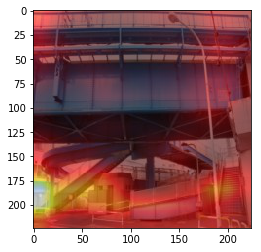

In [214]:
fo.single_cam(image_id=0, cls="urban outdoor")

In [263]:
cams = fo.all_cams()

loading cams


In [264]:
thresholds = fo.quantile_threshold(features=cams)

loading quantile threshold


In [260]:
iou = fo.iou(cams, thresholds)

labelprobe image index 0
labelprobe image index 16
labelprobe image index 32
labelprobe image index 48
labelprobe image index 64


/software/Anaconda3-5.0.1-el7-x86_64/envs/DL_GPU_cuda_9.0/lib/python3.6/site-packages/ipykernel/__main__.py:264: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


labelprobe image index 80
labelprobe image index 96
labelprobe image index 112
labelprobe image index 128
labelprobe image index 144
labelprobe image index 160
labelprobe image index 176
labelprobe image index 192
labelprobe image index 208
labelprobe image index 224
labelprobe image index 240
labelprobe image index 256
labelprobe image index 272
labelprobe image index 288
labelprobe image index 304
labelprobe image index 320
labelprobe image index 336
labelprobe image index 352
labelprobe image index 368
labelprobe image index 384
labelprobe image index 400
labelprobe image index 416
labelprobe image index 432
labelprobe image index 448
labelprobe image index 464
labelprobe image index 480
labelprobe image index 496
labelprobe image index 512
labelprobe image index 528
labelprobe image index 544
labelprobe image index 560
labelprobe image index 576
labelprobe image index 592
labelprobe image index 608
labelprobe image index 624
labelprobe image index 640
labelprobe image index 656
lab

labelprobe image index 4816
labelprobe image index 4832
labelprobe image index 4848
labelprobe image index 4864
labelprobe image index 4880
labelprobe image index 4896
labelprobe image index 4912
labelprobe image index 4928
labelprobe image index 4944
labelprobe image index 4960
labelprobe image index 4976
labelprobe image index 4992
labelprobe image index 5008
labelprobe image index 5024
labelprobe image index 5040
labelprobe image index 5056
labelprobe image index 5072
labelprobe image index 5088
labelprobe image index 5104
labelprobe image index 5120
labelprobe image index 5136
labelprobe image index 5152
labelprobe image index 5168
labelprobe image index 5184
labelprobe image index 5200
labelprobe image index 5216
labelprobe image index 5232
labelprobe image index 5248
labelprobe image index 5264
labelprobe image index 5280
labelprobe image index 5296
labelprobe image index 5312
labelprobe image index 5328
labelprobe image index 5344
labelprobe image index 5360
labelprobe image ind

ValueError: operands could not be broadcast together with shapes (1197,) (1198,) (1197,) 

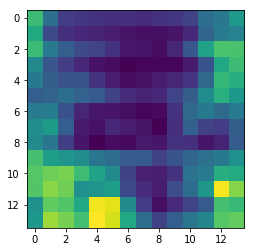

In [219]:
plt.imshow(cams[0][0])

In [227]:
cams[0].shape

(3, 14, 14)

In [225]:
m0 = np.max(cams[0][0])
m1 = np.max(cams[0][1])
m2 = np.max(cams[0][2])
print("m0: {}, m1: {}, m2: {}".format(m0, m1, m2))

m0: 7.875183935960877, m1: 9.000870750350689, m2: 16.993121758054812


In [122]:
# check number of each classes
num_indoor = int(np.sum(binary[:, 0]))
num_nature = int(np.sum(binary[:, 1]))
num_urban = int(np.sum(binary[:, 2]))
print("indoor: {}, nature: {}, urban outdoor: {}".format(num_indoor, num_nature, num_urban))

indoor: 40217, nature: 6542, urban outdoor: 16546


In [215]:
binary[0]

array([0., 0., 1.])

In [213]:
matrix[0]

array([0.04034417, 0.05535179, 0.90430403])

In [230]:
thresholds.shape

(3,)

In [231]:
thresholds

array([20.8467122 , 15.19618321, 15.01666848])

In [117]:
img_path = images[403]['image']
img = Image.open(os.path.join(DATA_DIRECTORY, "images", img_path))

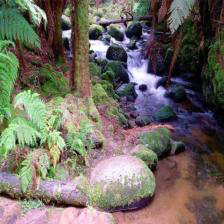

In [118]:
img

In [16]:
# feed image forward to attain feature map
def forward_image(images, inds, features_blobs, m, verbose=True, memmap=True):
    # intialize an empty matrix to store all result
    matrix = np.zeros((len(inds), 3))
    
    # intialize arrays to store max feature maps
    maxfeatures = [None] * len(features_names)
    mmap_max_files = [os.path.join(OUTPUT_FOLDER, "%s_max.mmap" % feature_name) for feature_name in features_names]
    size_features = (len(inds), 512)
    for i in range(len(features_names)):
        if memmap:
            maxfeatures[i] = np.memmap(mmap_max_files[i],dtype=float,mode='w+',shape=size_features)
        else:
            maxfeatures[i] = np.zeros(size_features)
    
    # intialize arrays to store feature maps
    wholefeatures = [None] * len(features_names)
    mmap_files =  [os.path.join(OUTPUT_FOLDER, "%s.mmap" % feature_name)  for feature_name in features_names]
    size_features = (len(inds), 512, 14, 14)
    for i in range(len(features_names)):
        if memmap:
            wholefeatures[i] = np.memmap(mmap_files[i], dtype=float, mode='w+', shape=size_features)
        else:
            wholefeatures[i] = np.zeros(size_features)
    
    #features_size = [None] * len(features_names)
    #features_size_file = os.path.join(OUTPUT_FOLDER, "feature_size.npy")
    
    # image transformer
    tf = returnTF() 
    
    for i, ind in enumerate(inds):
        del features_blobs[:]
        if (i % 100 == 0):
            print("image: {}".format(i))
            verbose = True
        img_path = os.path.join(DATA_DIRECTORY, "images", images[ind]["image"])
        img = Image.open(img_path)
    
        tf_img = tf(img)
        #display_tf_img = np.rollaxis(tf_img.numpy(),0,3)
    
        input_img = V(tf_img.unsqueeze(0))
        #print(input_img.shape)
        logit = m.forward(input_img)
        
        for j, feat_batch in enumerate(features_blobs):
            wholefeatures[j][i] = feat_batch
            maxfeatures[j][i] = np.max(np.max(feat_batch,3),2)
        
        h_x = F.softmax(logit, 1).data.squeeze()
        probs, idx = h_x.sort(0, True)
        probs, idx = probs.numpy(), idx.numpy()
    
        for j in range(0, 3):
            matrix[i][idx[j]] = probs[j]
        if verbose:
            print('--- SCENE CATEGORIES ---')
            for j in range(0, 3):
                print('{:.3f} -> {}'.format(probs[j], classes[idx[j]]))
            verbose = False
        
    matrix_path = os.path.join(OUTPUT_FOLDER, "classification.npy")
    np.save(matrix_path, matrix)
    return maxfeatures, wholefeatures, matrix

In [26]:
tf = returnTF() 

In [27]:
tf_img = tf(img)

In [32]:
tf_img.shape

torch.Size([3, 224, 224])

In [43]:
input_img = V(tf_img.unsqueeze(0))

In [44]:
input_img.shape

torch.Size([1, 3, 224, 224])

In [45]:
type(input_img)

torch.Tensor

In [51]:
logit = model.forward(input_img)

In [52]:
logit.shape

torch.Size([1, 3])

In [54]:
type(logit)

torch.Tensor

In [56]:
logit

tensor([[ 2.9850,  3.2229,  3.9066]])

In [60]:
features_blobs[0].shape

(1, 512, 14, 14)

In [19]:
# image transformer
def returnTF():
    tf = trn.Compose([
        trn.Resize((224,224)),
        trn.ToTensor(),
        trn.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # why normalize it this way? # need to calculate the mean again
    ])
    return tf

In [ ]:
# GPU is currently not available, use CPU for feed forward
imgs = np.arange(len(images))
print("total number of images: {}".format(len(images)))
mfs, wfs, matrix = forward_image(images, imgs, features_blobs, model)

total number of images: 63305
image: 0
--- SCENE CATEGORIES ---
0.526 -> urban outdoor
0.265 -> nature
0.209 -> indoor
image: 100
--- SCENE CATEGORIES ---
0.594 -> indoor
0.309 -> urban outdoor
0.097 -> nature
image: 200
--- SCENE CATEGORIES ---
0.904 -> indoor
0.076 -> urban outdoor
0.020 -> nature
image: 300
--- SCENE CATEGORIES ---
0.736 -> indoor
0.197 -> urban outdoor
0.067 -> nature
image: 400
--- SCENE CATEGORIES ---
0.454 -> indoor
0.408 -> urban outdoor
0.137 -> nature
image: 500
--- SCENE CATEGORIES ---
0.671 -> urban outdoor
0.203 -> indoor
0.126 -> nature
image: 600
--- SCENE CATEGORIES ---
0.499 -> indoor
0.320 -> nature
0.180 -> urban outdoor
image: 700
--- SCENE CATEGORIES ---
0.940 -> indoor
0.052 -> urban outdoor
0.009 -> nature
image: 800
--- SCENE CATEGORIES ---
0.975 -> indoor
0.023 -> urban outdoor
0.003 -> nature
image: 900
--- SCENE CATEGORIES ---
0.905 -> indoor
0.061 -> urban outdoor
0.033 -> nature
image: 1000
--- SCENE CATEGORIES ---
0.457 -> nature
0.402 -> 

image: 8900
--- SCENE CATEGORIES ---
0.760 -> indoor
0.183 -> urban outdoor
0.057 -> nature
image: 9000
--- SCENE CATEGORIES ---
0.737 -> nature
0.139 -> indoor
0.124 -> urban outdoor
image: 9100
--- SCENE CATEGORIES ---
0.699 -> indoor
0.227 -> urban outdoor
0.075 -> nature
image: 9200
--- SCENE CATEGORIES ---
0.825 -> indoor
0.113 -> urban outdoor
0.062 -> nature
image: 9300
--- SCENE CATEGORIES ---
0.518 -> nature
0.265 -> indoor
0.217 -> urban outdoor
image: 9400
--- SCENE CATEGORIES ---
0.805 -> indoor
0.126 -> urban outdoor
0.069 -> nature
image: 9500
--- SCENE CATEGORIES ---
0.821 -> indoor
0.111 -> urban outdoor
0.068 -> nature
image: 9600
--- SCENE CATEGORIES ---
0.993 -> indoor
0.006 -> urban outdoor
0.001 -> nature
image: 9700
--- SCENE CATEGORIES ---
0.694 -> urban outdoor
0.208 -> indoor
0.098 -> nature
image: 9800
--- SCENE CATEGORIES ---
0.931 -> indoor
0.057 -> urban outdoor
0.012 -> nature
image: 9900
--- SCENE CATEGORIES ---
0.669 -> nature
0.201 -> indoor
0.130 -> ur

image: 17800
--- SCENE CATEGORIES ---
0.649 -> indoor
0.235 -> urban outdoor
0.116 -> nature
image: 17900
--- SCENE CATEGORIES ---
0.432 -> nature
0.329 -> urban outdoor
0.238 -> indoor
image: 18000
--- SCENE CATEGORIES ---
0.591 -> indoor
0.240 -> urban outdoor
0.169 -> nature
image: 18100
--- SCENE CATEGORIES ---
0.890 -> nature
0.063 -> urban outdoor
0.047 -> indoor
image: 18200
--- SCENE CATEGORIES ---
0.949 -> indoor
0.044 -> urban outdoor
0.007 -> nature
image: 18300
--- SCENE CATEGORIES ---
0.936 -> indoor
0.048 -> urban outdoor
0.015 -> nature
image: 18400
--- SCENE CATEGORIES ---
0.660 -> nature
0.182 -> urban outdoor
0.158 -> indoor
image: 18500
--- SCENE CATEGORIES ---
0.503 -> indoor
0.359 -> urban outdoor
0.138 -> nature
image: 18600
--- SCENE CATEGORIES ---
0.515 -> indoor
0.276 -> urban outdoor
0.209 -> nature
image: 18700
--- SCENE CATEGORIES ---
0.570 -> urban outdoor
0.272 -> indoor
0.158 -> nature
image: 18800
--- SCENE CATEGORIES ---
0.759 -> indoor
0.154 -> urban o

--- SCENE CATEGORIES ---
0.380 -> indoor
0.338 -> urban outdoor
0.282 -> nature
image: 26700
--- SCENE CATEGORIES ---
0.505 -> indoor
0.272 -> nature
0.223 -> urban outdoor
image: 26800
--- SCENE CATEGORIES ---
0.842 -> indoor
0.120 -> urban outdoor
0.038 -> nature
image: 26900
--- SCENE CATEGORIES ---
0.412 -> indoor
0.323 -> nature
0.265 -> urban outdoor
image: 27000
--- SCENE CATEGORIES ---
0.737 -> indoor
0.133 -> nature
0.130 -> urban outdoor
image: 27100
--- SCENE CATEGORIES ---
0.438 -> nature
0.437 -> urban outdoor
0.125 -> indoor
image: 27200
--- SCENE CATEGORIES ---
0.973 -> indoor
0.021 -> urban outdoor
0.006 -> nature
image: 27300
--- SCENE CATEGORIES ---
0.692 -> indoor
0.234 -> urban outdoor
0.074 -> nature
image: 27400
--- SCENE CATEGORIES ---
0.716 -> indoor
0.167 -> urban outdoor
0.117 -> nature
image: 27500
--- SCENE CATEGORIES ---
0.840 -> indoor
0.145 -> urban outdoor
0.015 -> nature
image: 27600
--- SCENE CATEGORIES ---
0.666 -> indoor
0.242 -> urban outdoor
0.092 

image: 35500
--- SCENE CATEGORIES ---
0.639 -> indoor
0.226 -> nature
0.134 -> urban outdoor
image: 35600
--- SCENE CATEGORIES ---
0.936 -> indoor
0.039 -> urban outdoor
0.025 -> nature
image: 35700
--- SCENE CATEGORIES ---
0.764 -> indoor
0.172 -> urban outdoor
0.064 -> nature
image: 35800
--- SCENE CATEGORIES ---
0.913 -> indoor
0.050 -> nature
0.037 -> urban outdoor
image: 35900
--- SCENE CATEGORIES ---
0.588 -> nature
0.225 -> urban outdoor
0.187 -> indoor
image: 36000
--- SCENE CATEGORIES ---
0.567 -> indoor
0.281 -> urban outdoor
0.153 -> nature
image: 36100
--- SCENE CATEGORIES ---
0.675 -> indoor
0.254 -> urban outdoor
0.071 -> nature
image: 36200
--- SCENE CATEGORIES ---
0.593 -> indoor
0.300 -> urban outdoor
0.106 -> nature
image: 36300
--- SCENE CATEGORIES ---
0.485 -> urban outdoor
0.453 -> indoor
0.062 -> nature
image: 36400
--- SCENE CATEGORIES ---
0.716 -> indoor
0.220 -> urban outdoor
0.064 -> nature
image: 36500
--- SCENE CATEGORIES ---
0.780 -> indoor
0.153 -> urban o

--- SCENE CATEGORIES ---
0.504 -> indoor
0.352 -> nature
0.143 -> urban outdoor
image: 44400
--- SCENE CATEGORIES ---
0.640 -> urban outdoor
0.265 -> nature
0.095 -> indoor
image: 44500
--- SCENE CATEGORIES ---
0.586 -> nature
0.267 -> indoor
0.147 -> urban outdoor
image: 44600
--- SCENE CATEGORIES ---
0.715 -> nature
0.173 -> urban outdoor
0.112 -> indoor
image: 44700
--- SCENE CATEGORIES ---
0.718 -> indoor
0.236 -> urban outdoor
0.046 -> nature
image: 44800
--- SCENE CATEGORIES ---
0.753 -> indoor
0.219 -> urban outdoor
0.028 -> nature
image: 44900
--- SCENE CATEGORIES ---
0.515 -> urban outdoor
0.368 -> nature
0.117 -> indoor
image: 45000
--- SCENE CATEGORIES ---
0.860 -> indoor
0.095 -> urban outdoor
0.045 -> nature
image: 45100
--- SCENE CATEGORIES ---
0.900 -> indoor
0.079 -> urban outdoor
0.021 -> nature
image: 45200
--- SCENE CATEGORIES ---
0.479 -> indoor
0.282 -> nature
0.240 -> urban outdoor
image: 45300
--- SCENE CATEGORIES ---
0.750 -> indoor
0.125 -> nature
0.124 -> urba

In [13]:
mfs[0].shape

NameError: name 'mfs' is not defined

In [55]:
wfs[0].shape

(10, 512, 14, 14)

In [56]:
wfs[0]

memmap([[[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
           0.00000000e+00, 0.00000000e+00, 1.79981172e-01],
          [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
           0.00000000e+00, 0.00000000e+00, 1.28359795e-01],
          [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
           0.00000000e+00, 0.00000000e+00, 1.22119382e-01],
          ...,
          [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
           0.00000000e+00, 0.00000000e+00, 1.91296116e-01],
          [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
           0.00000000e+00, 0.00000000e+00, 1.74146518e-01],
          [1.18112177e-01, 9.62563306e-02, 6.76690489e-02, ...,
           6.74347430e-02, 9.61728841e-02, 2.87601680e-01]],

         [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
           0.00000000e+00, 0.00000000e+00, 1.16969429e-01],
          [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
           0.00000000e+00, 0.00000000e+00, 1.189224

In [15]:
imgs = np.arange(len(fo.loader.indexes))
mmap_file = os.path.join(OUTPUT_FOLDER, "layer4.mmap")
t = np.memmap(mmap_file, dtype=float,mode='r', shape=(len(imgs), 512, 14, 14))

In [16]:
t.shape

(63305, 512, 14, 14)

In [17]:
t[596]

memmap([[[0.12603618, 0.09246899, 0.1196951 , ..., 0.        ,
          0.00297683, 0.22580793],
         [0.10602508, 0.06732225, 0.06542509, ..., 0.        ,
          0.        , 0.20222527],
         [0.15837519, 0.11803124, 0.05271953, ..., 0.        ,
          0.        , 0.15537906],
         ...,
         [0.053291  , 0.        , 0.        , ..., 0.        ,
          0.        , 0.1250512 ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.01461095, 0.22852263],
         [0.197024  , 0.18409301, 0.18803969, ..., 0.02878998,
          0.0652594 , 0.26246139]],

        [[0.15647575, 0.13230076, 0.17982605, ..., 0.        ,
          0.13270649, 0.19962728],
         [0.16886963, 0.05948209, 0.02479741, ..., 0.        ,
          0.05344396, 0.15411797],
         [0.13801898, 0.03026319, 0.        , ..., 0.        ,
          0.        , 0.07942212],
         ...,
         [0.11102009, 0.        , 0.        , ..., 0.        ,
          0.        , 0.1

In [32]:
t[8800]

memmap([[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
    